# **East Africa drought study - model fitting**

In [153]:
source("../wwa_nonstationary_fitting.r")

# load precip data and convert to log for fitting purposes
# df <- read.csv("data/gmst-nino-chirps.csv")
df <- read.csv("data/gmst-nino-cpc.csv")

---
## **Linear model fits**

- Choose parameters by fitting linear model & checking significance
- Treat GMST and Nino3.4rel as independent, since Nino index is detrended

In [154]:
df <- read.csv("data/gmst-nino-chirps.csv")
df <- cbind(df[,! colnames(df) %in% c("pr_ond", "pr_mam", "pr12", "pr24")], sapply(c("pr_ond", "pr_mam", "pr12", "pr24"), function(v) log(df[,v]))) # use log10 to match climate explorer    

In [155]:
rbind.fill(sapply(colnames(df)[grepl("^pr", colnames(df))], function(v) {
    if(grepl("mam", v)) {
        nino = "nino_mam"
    } else {
        nino = "nino_ond"
    }
    summ_gmst <- summary(lm(get(v) ~ gmst, df))
    summ_nino <- summary(lm(get(v) ~ get(nino), df))
    summ_both <- summary(lm(get(v) ~ gmst + get(nino), df))
    
    data.frame("variable" = v, 
               # "nino_cov" = nino,
               "gmst" = c(paste0(round(summ_gmst$coefficients[-1,1], 4), c("", "*")[(summ_gmst$coefficients[-1,4] < 0.05) + 1])),
               "nino" = c(paste0(round(summ_nino$coefficients[-1,1], 4), c("", "*")[(summ_nino$coefficients[-1,4] < 0.05) + 1])),
               "both" = c(paste0(round(summ_both$coefficients[-1,1], 4), c("", "*")[(summ_both$coefficients[-1,4] < 0.05) + 1], collapse = " & ")))
}, simplify = F))

variable,gmst,nino,both
<chr>,<chr>,<chr>,<chr>
pr_ond,0.3246,0.1769*,0.4775* & 0.193*
pr_mam,-0.14,0.0359,-0.1217 & 0.0246
pr12,0.0589,0.0898*,0.1336 & 0.0944*
pr24,0.0955,0.0266,0.1215 & 0.0308


---
## **Check marginal fits**

In [121]:
df <- read.csv("data/gmst-nino-cpc.csv")
df <- cbind(df[,! colnames(df) %in% c("pr_ond", "pr_mam", "pr12", "pr24")], sapply(c("pr_ond", "pr_mam", "pr12", "pr24"), function(v) log10(df[,v]))) # ensures results match climate explorer

# check fitted parameters against climate explorer to confirm working properly
round(fit_ns("norm", "fixeddisp", df, varnm = "pr_ond", covnm_1 = "gmst", lower = T)$par, 3)  # expect 2.114, 0.193, 0.077
round(fit_ns("norm", "shift", df, varnm = "tas_ond", covnm_1 = "gmst", lower = F)$par, 3)     # expect 25.848, 0.492, 0.990

mu0 sigma0  alpha   beta 
 2.114  0.193  0.076  0.000

mu0 sigma0  alpha   beta 
25.849  0.492  0.990  0.000

In [122]:
# also check that results match for lognormal fitting / normal fitting to log precip
df <- read.csv("data/gmst-nino-cpc.csv")
df["log_pr"] <- log(df$pr_ond)

round(fit_ns("norm", "fixeddisp", df, varnm = "log_pr", covnm_1 = "gmst", lower = T)$par, 3)
round(fit_ns("lnorm", "fixeddisp", df, varnm = "pr_ond", covnm_1 = "gmst", lower = T)$par, 3)

mu0 sigma0  alpha   beta 
 4.867  0.444  0.174  0.000

mu0 sigma0  alpha   beta 
 4.867  0.444  0.174  0.000

---
## **Bivariate analysis using ``copula`` package**

### **Test by replicating Mariam's analysis**

In [160]:
df <- read.csv("data/gmst-nino-cpc.csv")

gmst_2022 <- df[df$year == 2022, "gmst"]
gmst_cf <- gmst_2022 - 1.2

In [165]:
# check: results are identical whether we use pr or log(pr)
rbind(model_res(fit_ns("norm", "fixeddisp", df, varnm = "log10pr_ond", covnm_1 = "gmst", lower = T), x = df[df$year == 2022, "log10pr_ond"], cov1_hist = gmst_cf),
      model_res(fit_ns("lnorm", "fixeddisp", df, varnm = "pr_ond", covnm_1 = "gmst", lower = T), x = df[df$year == 2022, "pr_ond"], cov1_hist = gmst_cf))

,dist,fit_type,mu0,sigma0,alpha,beta,var.disp,rl_obs,rl_cf,delta_I,delta_I_rel,rp_obs,rp_cf,prob_ratio
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
log10pr_ond ~ gmst,norm,fixeddisp,2.124400,0.1950427,0.06003521,0,0.09181073,1.937807,1.873195,0.0646128,FALSE,8.849511,5.254814,0.5937971
pr_ond ~ gmst,lnorm,fixeddisp,4.891491,0.4491551,0.13837767,0,0.09182377,86.657745,74.666879,11.9908664,FALSE,8.847281,5.251393,0.5935601


In [166]:
# fit marginal distributions
# df["log_pr"] <- log10(df$pr_ond); mdl_pr <- fit_ns("norm", "fixeddisp", df, varnm = "log_pr", covnm_1 = "gmst", lower = T)
mdl_pr <- fit_ns("lnorm", "fixeddisp", df, varnm = "pr_ond", covnm_1 = "gmst", lower = T)
mdl_tas <- fit_ns("norm", "shift", df, varnm = "pet_ond", covnm_1 = "gmst", lower = F)

# transform marginals to U
u_pr <- map_to_u(mdl_pr, mdl_pr$x)
u_tas <- map_to_u(mdl_tas, mdl_tas$x)

# fit copula to u,v pairs
fitted_copula <- fitCopula(tCopula(), data = cbind(u_pr, u_tas), hideWarnings = T)  # warning message about using df.fixed is irrelevant: can't actually change this setting
cfit <- tCopula(coef(fitted_copula)["rho.1"], df = round(coef(fitted_copula)["df"], 0))  # has to be integer df for pCopula

In [167]:
jmodel_res(mdl_pr, mdl_tas, cfit, x = mdl_pr$x[mdl_pr$ev_idx], y = mdl_tas$x[mdl_tas$ev_idx], cov1_hist = gmst_cf)

,dist,fit_type,mu0,sigma0,alpha,beta,var.disp,rl_obs,rl_cf,delta_I,delta_I_rel,rp_obs,rp_cf,prob_ratio
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
pr_ond ~ gmst,lnorm,fixeddisp,4.891491,0.4491551,0.1383777,0,0.09182377,86.65775,74.66688,11.990866,FALSE,8.847281,5.251393,0.5935601
pet_ond ~ gmst,norm,shift,12.625642,0.9683694,1.7164096,0,0.96836943,14.48540,12.42571,2.059691,FALSE,2.606415,129.868253,49.8264001
joint,tCopula,stationary,NA,NA,NA,NA,0.67121649,NA,NA,NA,NA,10.499247,147.282511,14.0279121


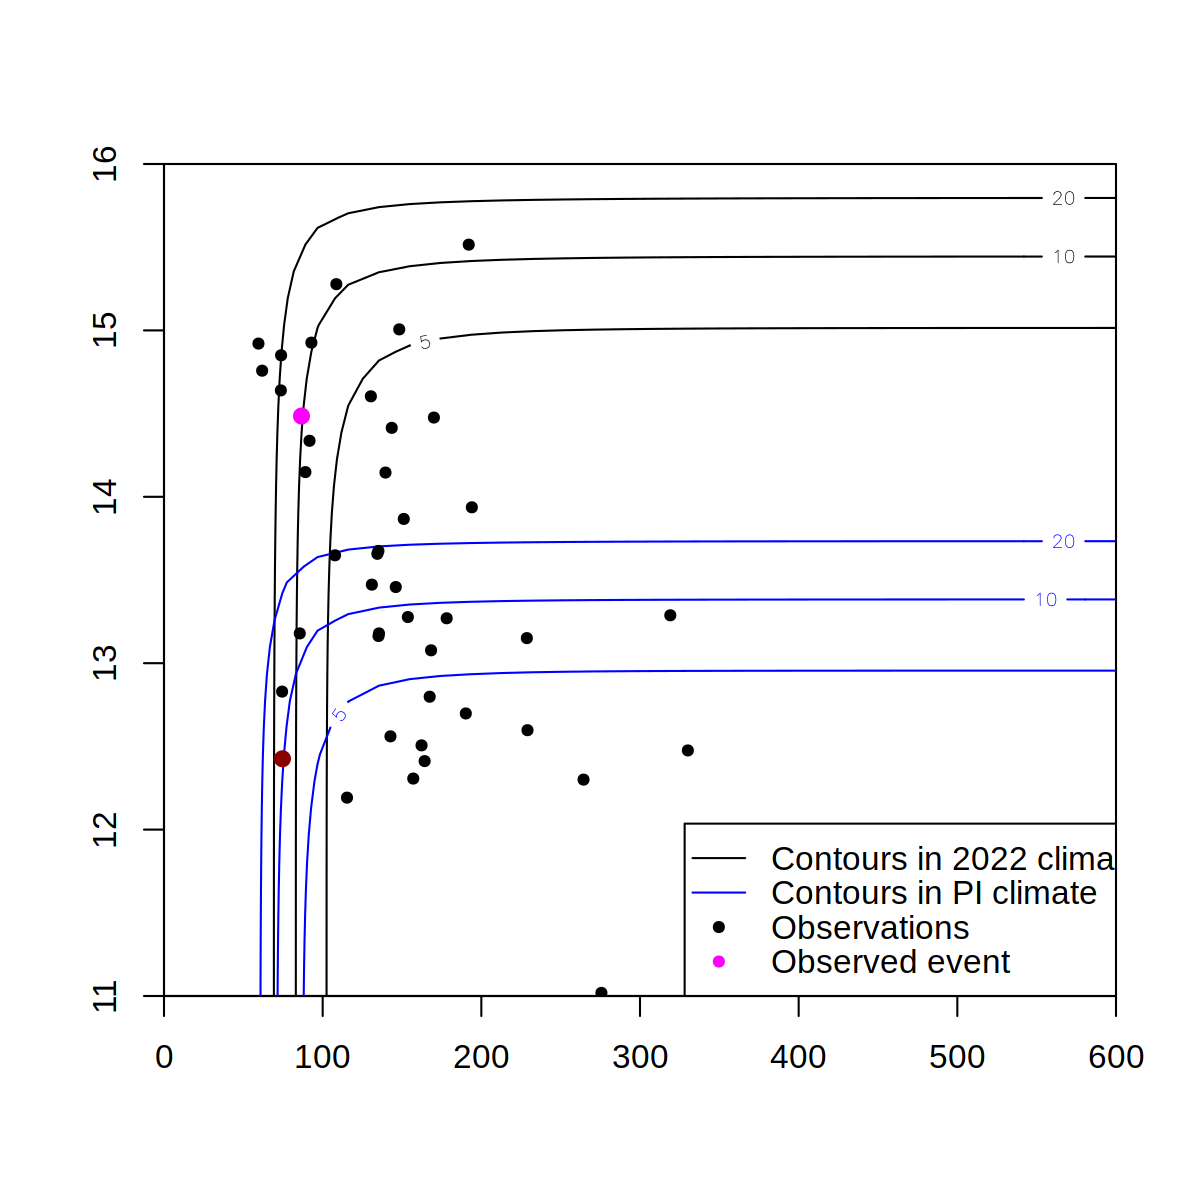

In [169]:
par(pch = 20, xaxs = "i", yaxs = "i")

contour(copula_mesh(mdl_pr, mdl_tas, cfit, df$gmst[df$year == 2022]), levels = 1/c(5,10,20), labels = c(5,10,20))
contour(copula_mesh(mdl_pr, mdl_tas, cfit, df$gmst[df$year == 2022] - 1.2), levels = 1/c(5,10,20), labels = c(5,10,20), col = "blue", add = T)
points(mdl_pr$x, mdl_tas$x, pch = 20)
points(mdl_pr$x[df$year == 2022], mdl_tas$x[df$year == 2022], pch = 20, col = "magenta", cex = 1.5)

# add event of same magnitude in historical climate
points(map_from_u(u_pr[df$year == 2022], mdl_pr, cov1 = gmst_cf),
       map_from_u(u_tas[df$year == 2022], mdl_tas, cov1 = gmst_cf), col = "darkred", cex = 1.5)

legend("bottomright", c("Contours in 2022 climate", "Contours in PI climate", "Observations", "Observed event"), col = c("black", "blue", "black", "magenta"), lty = c(1,1,NA,NA), pch = c(NA,NA,20,20))

### **Panel plot of fitted models**

- needs to be modified to work with new functions above

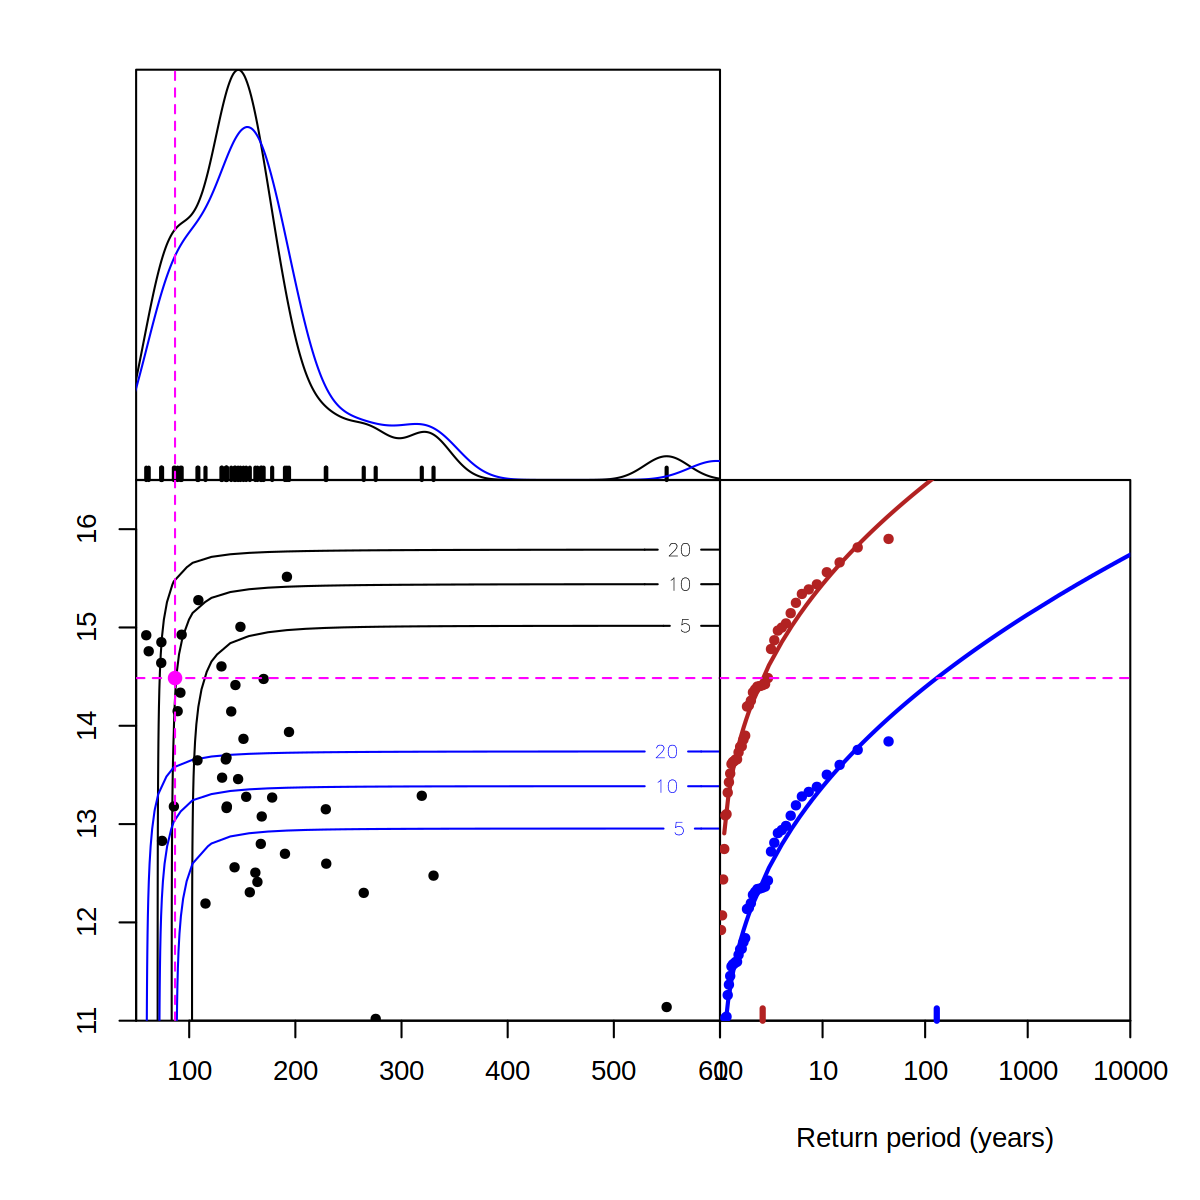

In [170]:
rc = c(1,1); w = 6; h = w; options(repr.plot.width = rc[2]*w, repr.plot.height = rc[1]*h, repr.plot.res = 200); par(mfrow = rc, pch = 20, xaxs = "i", yaxs = "i")
layout(matrix(c(1,2,3,4),2,2), widths = c(3,2), heights = c(2,3))

xrange = c(50,600)
yrange = c(11,16.5)

par(mar = c(0,4.1,2.1,0))
plot(density(mdl_pr$x), xaxt = "n", yaxt = "n", xlab = "", xlim = xrange, ylab = "", main = "", col = "black")
rug(mdl_pr$x, lwd = 2)
lines(density(map_from_u(map_to_u(mdl_pr), mdl_pr, cov1 = df$gmst[df$year == 2022])), xaxt = "n", yaxt = "n", xlab = "", xlim = xrange, ylab = "", main = "", col = "blue")
abline(v = mdl_pr$x[df$year == "2022"], col = "magenta", lty = 2)
# plot_returnperiods(mdl_pr, cov1 = df$gmst[df$year == 2022], cov2 = df$gmst[df$year == 2022] - 1.2, event_value = mdl_pr$x[df$year == 2022])

par(mar = c(5.4,4.1,0,0))
contour(copula_mesh(mdl_pr, mdl_tas, cfit, df$gmst[df$year == 2022], xrange = xrange, yrange = yrange), levels = 1/c(5,10,20), labels = c(5,10,20))
contour(copula_mesh(mdl_pr, mdl_tas, cfit, df$gmst[df$year == 2022] - 1.2, xrange = xrange, yrange = yrange), levels = 1/c(5,10,20), labels = c(5,10,20), col = "blue", add = T)
points(mdl_pr$x, mdl_tas$x, pch = 20)
points(mdl_pr$x[df$year == 2022], mdl_tas$x[df$year == 2022], pch = 20, col = "magenta", cex = 1.5)
abline(v = mdl_pr$x[df$year == 2022], h = mdl_tas$x[df$year == 2022], col = "magenta", lty = 2)

# points(map_from_u(map_to_u(mdl_pr), mdl_pr, df$gmst[df$year == 2022] - 1.2), map_from_u(map_to_u(mdl_tas), mdl_tas, df$gmst[df$year == 2022] - 1.2), pch = 4, col = "blue")
# points(map_from_u(map_to_u(mdl_pr), mdl_pr, df$gmst[df$year == 2022]), map_from_u(map_to_u(mdl_tas), mdl_tas, df$gmst[df$year == 2022] ), pch = 4, col = "firebrick")


plot.new()
# par(mar = c(0,0,2.1,2.1))
# contour(MASS::kde2d(map_to_u(mdl_pr), map_to_u(mdl_tas)), col = "skyblue", main = "", xaxt = "n", yaxt = "n")
# points(map_to_u(mdl_pr), map_to_u(mdl_tas), pch = 4, col = "cornflowerblue")
# contour(cfit, dCopula, add = T)

par(mar = c(5.4,0,0,2.1))
# plot.new()
# dns <- density(mdl_tas$x)
# dns_hist <- density(map_from_u(map_to_u(mdl_tas), mdl_tas, cov1 = df$gmst[df$year == 2022]))
# plot(dns$y, dns$x, yaxt = "n", xaxt = "n", xlab = "", ylim = yrange, type = "l", col = "black", xlim = range(c(dns$y, dns_hist$y)))
# rug(mdl_tas$x, side = 2, lwd = 2)
# abline(h = mdl_tas$x[df$year == "2022"], col = "magenta", lty = 2)
# lines(dns_hist$y, dns_hist$x, col = "blue")
plot_returnperiods(mdl_tas, cov1 = df$gmst[df$year == 2022], cov2 = df$gmst[df$year == 2022] - 1.2, event_value = mdl_tas$x[df$year == 2022], legend_pos = NA, yaxt = "n", ylim = yrange)

# probably better to replot with CDF on each axis? Or return level plot?

### **Fit & get results (CPC)**

In [182]:
joint_model_qfit <- function(mdl_1, mdl_2, cov1_hist, cov2_hist = 0, x = NA, y = NA, dI_x_rel = F, dI_y_rel = F) {
    
    # fit copula to u,v pairs
    fitted_copula <- fitCopula(tCopula(), data = cbind(map_to_u(mdl_1), map_to_u(mdl_2)), hideWarnings = T)  # warning message about using df.fixed is irrelevant: can't actually change this setting
    cfit <- tCopula(coef(fitted_copula)["rho.1"], df = round(coef(fitted_copula)["df"], 0))  # has to be integer df for pCopula
    
    if(is.na(x)) { x <- mdl_1$x[length(mdl_1$x)]}
    if(is.na(y)) { y <- mdl_2$x[length(mdl_2$x)]}
        
    res <- jmodel_res(mdl_1, mdl_2, cfit, x = x, y = y, cov1_hist = cov1_hist, cov2_hist = cov2_hist, dI_x_rel = dI_x_rel, dI_y_rel = dI_y_rel)
    return(res)
}

In [208]:
joint_model_qfit(fit_ns("norm", "fixeddisp", df, varnm = "log10pr12", covnm_1 = "gmst", lower = T), 
                 fit_ns("norm", "shift", df, varnm = "pet_12", covnm_1 = "gmst", lower = F),
                 cov1_hist = event_gmst-1.2, dI_x_rel = T)

,dist,fit_type,mu0,sigma0,alpha,beta,var.disp,rl_obs,rl_cf,delta_I,delta_I_rel,rp_obs,rp_cf,prob_ratio
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
log10pr12 ~ gmst,norm,fixeddisp,2.632432,0.1058858,-0.04450388,0,0.04022358,2.44576,2.495884,-2.008279,TRUE,12.434452,32.77675,2.635963
pet_12 ~ gmst,norm,shift,52.260958,2.6829652,8.61142022,0,2.68296520,60.52379,50.190088,10.333704,FALSE,2.246124,30188.80711,13440.401915
joint,tCopula,stationary,NA,NA,NA,NA,0.49593477,NA,NA,NA,NA,15.346762,50468.37368,3288.535649


In [224]:
# w = 5; h = w; options(repr.plot.width = rc[2]*w, repr.plot.height = rc[1]*h, repr.plot.res = 200); 
mdl_1 <- fit_ns("norm", "fixeddisp", df, varnm = "log10pr_mam", covnm_1 = "gmst", covnm_2 = "nino_mam", lower = T)
mdl_2 <- fit_ns("norm", "fixeddisp", df, varnm = "log10pr_ond", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = T)

fitted_copula <- fitCopula(tCopula(), data = cbind(map_to_u(mdl_1), map_to_u(mdl_2)), hideWarnings = T)  # warning message about using df.fixed is irrelevant: can't actually change this setting
cfit <- tCopula(coef(fitted_copula)["rho.1"], df = round(coef(fitted_copula)["df"], 0))  # has to be integer df for pCopula

event_gmst <- mdl_1$cov1[mdl_1$ev_idx]
event_nino <- mdl_1$cov2[mdl_1$ev_idx]

event_value_1 <- mdl_1$x[mdl_1$ev_idx]
event_value_2 <- mdl_2$x[mdl_2$ev_idx]

rp_x <- unique(c(seq(1.1, 2, 0.1), seq(2, 100, 1), seq(100, 1000, 10), seq(100, 1000, 100), seq(1000, 10000, 1000)))
rp_th <- 1/seq(1, 0, length.out = length(mdl$x) + 2)[2:(length(mdl$x) + 1)]

png(paste0("fig/joint-model_",gsub("_","-",mdl_1$varnm),"_",gsub("_","-",mdl_2$varnm), "_gmst+nino.png"), width = 480 * 3, height = 480); {
    
    par(mfrow = c(1,3), pch = 20, xaxs = "i", yaxs = "i", cex = 1.25)
    
    plot_returnperiods(mdl_1, cov1 = event_gmst, cov2 = event_gmst - 1.2, event_value = event_value_1, legend_pos = NA, main = mdl_1$call)


    plot_returnperiods(mdl_2, cov1 = event_gmst, cov2 = event_gmst - 1.2, event_value = event_value_2, legend_pos = NA, main = mdl_2$call)
    
    contour(copula_mesh(mdl_1, mdl_2, cfit, event_gmst), levels = 1/c(5,10,20), labels = c(5,10,20), col = "red", main = "Joint exceedances", xlab = mdl_1$varnm, ylab = mdl_2$varnm)
    contour(copula_mesh(mdl_1, mdl_2, cfit, event_gmst-1.2), levels = 1/c(5,10,20), labels = c(5,10,20), col = "blue", add = T)
    
    points(mdl_1$x, mdl_2$x, pch = 20)
    points(event_value_1, event_value_2, pch = 20, col = "magenta", cex = 1.5)
}; dev.off()

jmodel_res(mdl_1, mdl_2, cfit, event_value_1, event_value_2, event_gmst - 1.2, event_nino)

png 
  2

,dist,fit_type,mu0,sigma0,alpha,beta,var.disp,rl_obs,rl_cf,delta_I,delta_I_rel,rp_obs,rp_cf,prob_ratio
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
log10pr_mam ~ gmst + nino_mam,norm,fixeddisp,2.313556,0.1475243,-0.1349806,0.02187111,0.06376516,2.002722,2.120364,-0.1176416,FALSE,11.53175,64.313824,5.5771078
log10pr_ond ~ gmst + nino_ond,norm,fixeddisp,2.098968,0.1682207,0.1180885,0.08073486,0.08014448,1.937807,1.718460,0.2193475,FALSE,16.09122,2.251674,0.1399319
joint,tCopula,stationary,NA,NA,NA,NA,0.03696446,NA,NA,NA,NA,163.02665,133.714421,0.8201998


---
## **Marginal distributions**

### **CHIRPS & CenTrends**

In [32]:
source("../wwa_nonstationary_fitting.r")

chirps <- read.csv("data/gmst-nino-chirps.csv")
centrends <- read.csv("data/gmst-nino-centrends.csv")

event_gmst <- chirps$gmst[chirps$year == 2022]
event_nino <- chirps$nino_ond[chirps$year == 2022]
event_chirps <- chirps$pr_ond[chirps$year == 2022]

chirps["log10pr_ond"] <- log10(chirps$pr_ond); chirps["log10pr_mam"] <- log10(chirps$pr_mam)
centrends["log10pr_ond"] <- log10(centrends$pr_ond); centrends["log10pr_mam"] <- log10(centrends$pr_mam)

chirps["logpr_ond"] <- log(chirps$pr_ond); chirps["logpr_mam"] <- log(chirps$pr_mam)
centrends["logpr_ond"] <- log(centrends$pr_ond); centrends["logpr_mam"] <- log(centrends$pr_mam)

chirps["log10pr12"] <- log10(chirps$pr12); chirps["log10pr12"] <- log10(chirps$pr12)
centrends["log10pr12"] <- log10(centrends$pr12); centrends["log10pr12"] <- log10(centrends$pr12)
chirps["logpr12"] <- log(chirps$pr12); chirps["logpr24"] <- log(chirps$pr24)
centrends["logpr12"] <- log(centrends$pr12); centrends["logpr24"] <- log(centrends$pr24)

centrends_recent <- centrends[centrends$year >= 1981,]


In [33]:
qfit <- function(mdl, dI_rel = F) {
    ds <- strsplit(toString(match.call()$mdl), ", ")[[1]][4]
    cbind("dataset" = ds, model_res(mdl, x = mdl$x[get(ds)$year == 2022], cov1_hist = event_gmst - 1.2, cov2_hist = event_nino, dI_rel = dI_rel))
}

pr_rel <- T

In [34]:
# check sensitivity to choice of fitting method
rbind(qfit(fit_ns("norm", "fixeddisp", centrends, varnm = "log10pr_ond", covnm_1 = "gmst", lower = T, method = "BFGS"), dI_rel = pr_rel),
      qfit(fit_ns("norm", "fixeddisp", centrends, varnm = "logpr_ond", covnm_1 = "gmst", lower = T), dI_rel = pr_rel),
      qfit(fit_ns("lnorm", "fixeddisp", centrends, varnm = "pr_ond", covnm_1 = "gmst", lower = T), dI_rel = pr_rel),
      qfit(fit_ns("norm", "fixeddisp", chirps, varnm = "log10pr_ond", covnm_1 = "gmst", lower = T), dI_rel = pr_rel),
      qfit(fit_ns("norm", "fixeddisp", chirps, varnm = "logpr_ond", covnm_1 = "gmst", lower = T), dI_rel = pr_rel),
      qfit(fit_ns("lnorm", "fixeddisp", chirps, varnm = "pr_ond", covnm_1 = "gmst", lower = T), dI_rel = pr_rel),
      qfit(fit_ns("norm", "fixeddisp", centrends_recent, varnm = "log10pr_ond", covnm_1 = "gmst", lower = T), dI_rel = pr_rel),
      qfit(fit_ns("lnorm", "fixeddisp", centrends_recent, varnm = "pr_ond", covnm_1 = "gmst", lower = T), dI_rel = pr_rel))

# something odd about CenTrends fitting - but otherwise, fitting method doesn't seem to make a difference

,dataset,dist,fit_type,converged,mu0,sigma0,alpha,beta,var.disp,rl_obs,rl_cf,delta_I,delta_I_rel,rp_obs,rp_cf,prob_ratio
,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
log10pr_ond ~ gmst,centrends,norm,fixeddisp,0,2.169745,0.1658185,0.08035123,0,0.07642300,2.119703,2.027568,4.544128,TRUE,4.288572,2.305653,0.5376271
logpr_ond ~ gmst,centrends,norm,fixeddisp,0,4.996008,0.3818135,0.18504722,0,0.07642371,4.880797,4.668612,4.544938,TRUE,4.288730,2.305516,0.5375756
pr_ond ~ gmst,centrends,lnorm,fixeddisp,0,4.996070,0.3818843,0.18449964,0,0.07643694,131.735630,106.615434,23.561500,TRUE,4.281886,2.306638,0.5386967
log10pr_ond ~ gmst1,chirps,norm,fixeddisp,0,2.134207,0.1687505,0.14055026,0,0.07906942,2.120520,1.959392,8.223371,TRUE,4.833038,1.779879,0.3682733
logpr_ond ~ gmst1,chirps,norm,fixeddisp,0,4.914189,0.3885686,0.32365923,0,0.07907075,4.882679,4.511634,8.224180,TRUE,4.833322,1.779839,0.3682434
pr_ond ~ gmst1,chirps,lnorm,fixeddisp,0,4.914048,0.3885847,0.32394982,0,0.07907630,131.983760,91.040427,44.972695,TRUE,4.835095,1.779119,0.3679594
log10pr_ond ~ gmst2,centrends_recent,norm,fixeddisp,0,2.168587,0.1720243,0.09798927,0,0.07932552,2.119703,2.007827,5.571993,TRUE,4.619066,2.221627,0.4809690
pr_ond ~ gmst2,centrends_recent,lnorm,fixeddisp,0,4.993385,0.3960432,0.22582558,0,0.07931357,131.735630,101.796510,29.410753,TRUE,4.622909,2.221540,0.4805502


In [35]:
mdl <- fit_ns("lnorm", "fixeddisp", centrends, varnm = "pr_ond", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = T)
fix_cov2 <- -1

cov1 <- cov_x <- mdl$cov1
cov2 <- fix_cov2
cov_nm <- mdl$covnm_1

# remove effect of unwanted covariate
y_adjusted <- map_from_u(map_to_u(mdl), mdl, cov1 = cov1, cov2 = cov2)

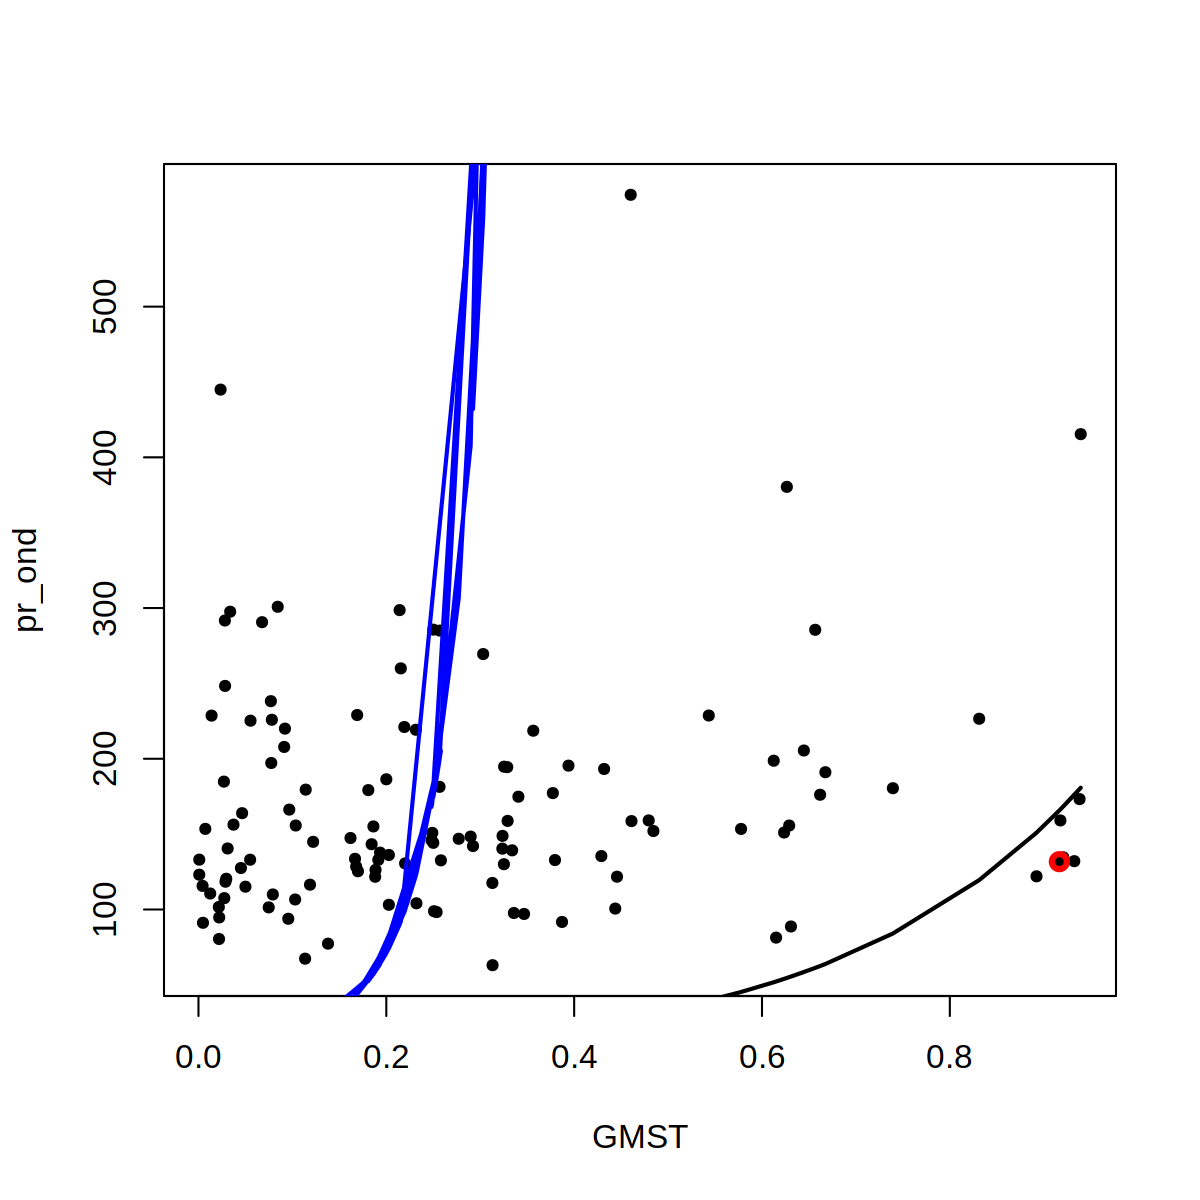

In [36]:
# ARGH

plot_covtrend <- function(mdl, fix_cov1 = NA, fix_cov2 = 0, legend_pos = "topright", ...) {
    
    # need some modification to accomodate two-parameter models
    if(!is.na(fix_cov1)) {
        # plot against first covariate
        cov1 <- cov_x <- mdl$cov1
        cov2 <- fix_cov2
        cov_nm <- mdl$covnm_1
    } else {
        # plot against second covariate
        cov1 <- fix_cov1
        cov2 <- cov_x <- mdl$cov2
        cov_nm <- mdl$covnm_2
    }
    
    # adjust observed values to account for the fixed covariate
    y_adjusted <- map_from_u(map_to_u(mdl), mdl, cov1 = cov1, cov2 = cov2)
    
    plot(cov_x, y_adjusted, pch = 20, xlab = toupper(cov_nm), ylab = mdl$varnm)
    points(cov_x[mdl$ev_idx], y_adjusted[mdl$ev_idx], col = "red", lwd = 3)
    
#     # abline(mdl$par["mu0"], mdl$par["alpha"])
    
    lines(cov_x, ns_pars(mdl, cov1 = cov1, cov2 = cov2)$loc, lwd = 2)
    lines(cov_x, map_from_u(1/6, mdl, cov1, cov2), col = "blue", lwd = 2)
    lines(cov_x, map_from_u(1/40, mdl, cov1, cov2), col = "blue", lwd = 1)
    
#     legend(legend_pos, legend = c("location", "1-in-6-year event", "1-in-40-year event"), lty = 1, col = c("black", "blue", "blue"), lwd = c(2,2,1))
}
plot_covtrend(mdl, fix_cov1 = event_gmst)

In [37]:
# add Nino3.4 index
rbind(qfit(fit_ns("norm", "fixeddisp", centrends, varnm = "log10pr_ond", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = T), dI_rel = pr_rel),
      qfit(fit_ns("norm", "fixeddisp", centrends, varnm = "logpr_ond", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = T), dI_rel = pr_rel),
      qfit(fit_ns("lnorm", "fixeddisp", centrends, varnm = "pr_ond", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = T), dI_rel = pr_rel),
      qfit(fit_ns("norm", "fixeddisp", chirps, varnm = "log10pr_ond", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = T), dI_rel = pr_rel),
      qfit(fit_ns("norm", "fixeddisp", chirps, varnm = "logpr_ond", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = T), dI_rel = pr_rel),
      qfit(fit_ns("lnorm", "fixeddisp", chirps, varnm = "pr_ond", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = T), dI_rel = pr_rel))

,dataset,dist,fit_type,converged,mu0,sigma0,alpha,beta,var.disp,rl_obs,rl_cf,delta_I,delta_I_rel,rp_obs,rp_cf,prob_ratio
,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
log10pr_ond ~ gmst + nino_ond,centrends,norm,fixeddisp,0,2.164130,0.1460972,0.1002509,0.07268652,0.06750853,2.119703,1.932919e+00,9.663322,TRUE,5.490340,1.495294,0.27234995
logpr_ond ~ gmst + nino_ond,centrends,norm,fixeddisp,0,4.983076,0.3364010,0.2308579,0.16737621,0.06750869,4.880797,4.450677e+00,9.664157,TRUE,5.490383,1.495207,0.27233207
pr_ond ~ gmst + nino_ond,centrends,lnorm,fixeddisp,1,4.956219,3.0746069,18.9761989,2.13718788,0.62035333,131.735630,1.031292e+00,12673.839546,TRUE,16.992251,1.000000,0.05885035
log10pr_ond ~ gmst + nino_ond1,chirps,norm,fixeddisp,0,2.108613,0.1376491,0.1978438,0.08024865,0.06527946,2.120520,1.817632e+00,16.663911,TRUE,8.445527,1.136987,0.13462598
logpr_ond ~ gmst + nino_ond1,chirps,norm,fixeddisp,0,4.855246,0.3169449,0.4555888,0.18476893,0.06527885,4.882679,4.185222e+00,16.664752,TRUE,8.446477,1.136971,0.13460887
pr_ond ~ gmst + nino_ond1,chirps,lnorm,fixeddisp,1,14.333260,5.9464777,-20.0988157,-2.21847095,0.41487265,131.983760,3.221180e+13,-100.000000,TRUE,1.404972,38.567000,27.45036793


In [38]:
# and for MAM
rbind(qfit(fit_ns("norm", "fixeddisp", centrends, varnm = "log10pr_mam", covnm_1 = "gmst", lower = T), dI_rel = pr_rel),
      qfit(fit_ns("norm", "fixeddisp", centrends, varnm = "logpr_mam", covnm_1 = "gmst", lower = T), dI_rel = pr_rel),
      qfit(fit_ns("lnorm", "fixeddisp", centrends, varnm = "pr_mam", covnm_1 = "gmst", lower = T), dI_rel = pr_rel),
      qfit(fit_ns("norm", "fixeddisp", chirps, varnm = "log10pr_mam", covnm_1 = "gmst", lower = T), dI_rel = pr_rel),
      qfit(fit_ns("norm", "fixeddisp", chirps, varnm = "logpr_mam", covnm_1 = "gmst", lower = T), dI_rel = pr_rel),
      qfit(fit_ns("lnorm", "fixeddisp", chirps, varnm = "pr_mam", covnm_1 = "gmst", lower = T), dI_rel = pr_rel))

,dataset,dist,fit_type,converged,mu0,sigma0,alpha,beta,var.disp,rl_obs,rl_cf,delta_I,delta_I_rel,rp_obs,rp_cf,prob_ratio
,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
log10pr_mam ~ gmst,centrends,norm,fixeddisp,0,2.314585,0.1297461,-0.03389213,0,0.05605586,2.161037,2.199345,-1.741795,TRUE,5.919537,9.505029,1.605705
logpr_mam ~ gmst,centrends,norm,fixeddisp,0,5.329556,0.2987525,-0.07805398,0,0.05605578,4.975972,5.064196,-1.742106,TRUE,5.919951,9.506658,1.605868
pr_mam ~ gmst,centrends,lnorm,fixeddisp,0,5.329505,0.2986694,-0.07814211,0,0.05604075,144.889590,158.269143,-8.453671,TRUE,5.918493,9.510827,1.606968
log10pr_mam ~ gmst1,chirps,norm,fixeddisp,0,2.353493,0.1127852,-0.05732376,0,0.04792245,2.159502,2.223552,-2.880524,TRUE,10.109284,31.217973,3.088050
logpr_mam ~ gmst1,chirps,norm,fixeddisp,0,5.419147,0.2596914,-0.13205324,0,0.04792108,4.972437,5.119985,-2.881809,TRUE,10.108222,31.232728,3.089834
pr_mam ~ gmst1,chirps,lnorm,fixeddisp,0,5.419100,0.2597883,-0.13234054,0,0.04793938,144.378270,167.387575,-13.746125,TRUE,10.079560,31.191929,3.094572


In [39]:
# and for annual precip
rbind(qfit(fit_ns("norm", "fixeddisp", centrends, varnm = "logpr12", covnm_1 = "gmst", lower = T), dI_rel = pr_rel),
      qfit(fit_ns("norm", "fixeddisp", centrends, varnm = "logpr12", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = T), dI_rel = pr_rel),
      qfit(fit_ns("norm", "fixeddisp", centrends, varnm = "logpr12", covnm_1 = "gmst", covnm_2 = "nino_12", lower = T), dI_rel = pr_rel),
      qfit(fit_ns("norm", "fixeddisp", chirps, varnm = "logpr12", covnm_1 = "gmst", lower = T), dI_rel = pr_rel),
      qfit(fit_ns("norm", "fixeddisp", chirps, varnm = "logpr12", covnm_1 = "gmst", covnm_2 = "nino_ond", lower = T), dI_rel = pr_rel),
      qfit(fit_ns("norm", "fixeddisp", chirps, varnm = "logpr12", covnm_1 = "gmst", covnm_2 = "nino_12", lower = T), dI_rel = pr_rel))

,dataset,dist,fit_type,converged,mu0,sigma0,alpha,beta,var.disp,rl_obs,rl_cf,delta_I,delta_I_rel,rp_obs,rp_cf,prob_ratio
,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
logpr12 ~ gmst,centrends,norm,fixeddisp,0,6.110263,0.2209607,0.01629876,0.00000000,0.03616223,5.834439,5.815793,0.3206057,TRUE,10.56751,9.118882,0.86291668
logpr12 ~ gmst + nino_ond,centrends,norm,fixeddisp,0,6.105012,0.2088750,0.03786113,0.06733498,0.03421369,5.834439,5.721888,1.9670273,TRUE,13.69619,5.491428,0.40094555
logpr12 ~ gmst + nino_12,centrends,norm,fixeddisp,0,6.093399,0.2038651,0.06688690,0.13125922,0.03345670,5.834439,5.624298,3.7363079,TRUE,16.73257,3.234328,0.19329534
logpr12 ~ gmst1,chirps,norm,fixeddisp,0,6.080908,0.2050244,0.06224382,0.00000000,0.03371609,5.831390,5.760200,1.2358877,TRUE,14.47448,7.793302,0.53841659
logpr12 ~ gmst + nino_ond1,chirps,norm,fixeddisp,0,6.050708,0.1727005,0.13403390,0.09353226,0.02854220,5.831390,5.583426,4.4410656,TRUE,38.95473,3.165532,0.08126181
logpr12 ~ gmst + nino_121,chirps,norm,fixeddisp,0,6.041855,0.1855447,0.15579374,0.12648115,0.03070989,5.831390,5.526006,5.5263003,TRUE,32.41295,2.316650,0.07147299


In [40]:
# and for 2-year accumulated precip
centrends_24 <- centrends[!is.na(centrends$pr24),]
chirps_24 <- chirps[!is.na(chirps$pr24),]

centrends_24$nino_ond2 <- (centrends[-nrow(centrends),"nino_ond"] + centrends[-1,"nino_ond"]) / 2
chirps_24$nino_ond2 <- (chirps[-nrow(chirps),"nino_ond"] + chirps[-1,"nino_ond"]) / 2

rbind(qfit(fit_ns("norm", "fixeddisp", centrends_24, varnm = "logpr24", covnm_1 = "gmst", lower = T), dI_rel = pr_rel),
      qfit(fit_ns("norm", "fixeddisp", centrends_24, varnm = "logpr24", covnm_1 = "gmst", covnm_2 = "nino_24", lower = T), dI_rel = pr_rel),
      qfit(fit_ns("norm", "fixeddisp", centrends_24, varnm = "logpr24", covnm_1 = "gmst", covnm_2 = "nino_ond2", lower = T), dI_rel = pr_rel),
      qfit(fit_ns("norm", "fixeddisp", chirps_24, varnm = "logpr24", covnm_1 = "gmst", lower = T), dI_rel = pr_rel),
      qfit(fit_ns("norm", "fixeddisp", chirps_24, varnm = "logpr24", covnm_1 = "gmst", covnm_2 = "nino_24", lower = T), dI_rel = pr_rel),
      qfit(fit_ns("norm", "fixeddisp", chirps_24, varnm = "logpr24", covnm_1 = "gmst", covnm_2 = "nino_ond2", lower = T), dI_rel = pr_rel))

,dataset,dist,fit_type,converged,mu0,sigma0,alpha,beta,var.disp,rl_obs,rl_cf,delta_I,delta_I_rel,rp_obs,rp_cf,prob_ratio
,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<lgl>,<dbl>,<dbl>,<dbl>
logpr24 ~ gmst,centrends_24,norm,fixeddisp,0,6.811198,0.1685789,0.02787008,0.00000000,0.02475026,6.561257,6.529119,0.4922239,TRUE,19.33226,13.281655,0.68702042
logpr24 ~ gmst + nino_24,centrends_24,norm,fixeddisp,0,6.796510,0.1562479,0.07114557,0.12784220,0.02298944,6.561257,6.347696,3.3643966,TRUE,35.35518,3.268350,0.09244332
logpr24 ~ gmst + nino_ond2,centrends_24,norm,fixeddisp,0,6.805704,0.1590880,0.05055679,0.07787753,0.02337569,6.561257,6.422319,2.1633639,TRUE,28.85755,5.677837,0.19675395
logpr24 ~ gmst1,chirps_24,norm,fixeddisp,0,6.766244,0.1512976,0.09642215,0.00000000,0.02236065,6.559513,6.448296,1.7247615,TRUE,37.22280,8.558756,0.22993315
logpr24 ~ gmst + nino_241,chirps_24,norm,fixeddisp,0,6.730697,0.1410677,0.17604655,0.10473890,0.02095886,6.559513,6.249779,4.9559243,TRUE,97.02837,2.109567,0.02174176
logpr24 ~ gmst + nino_ond21,chirps_24,norm,fixeddisp,0,6.737099,0.1353675,0.16266398,0.08577544,0.02009284,6.559513,6.284258,4.3800792,TRUE,113.19641,2.608057,0.02304011


## **Mapping PR & PET to SPEI**

In [1]:
# suppressMessages({ library(SPEI); library(flexsurv)} )
 library(SPEI)
effpr <- read.csv("data/cpc_effpr_monthly.csv") # use monthly time series for fitting

Loading required package: lmomco

Loading required package: parallel

Loading required package: ggplot2

# Package SPEI (1.7) loaded [try SPEINews()].



In [13]:
effpr_24 <- read.csv("ts/EA-drought_pr24_cpc.dat", comment = "#", sep = " ", header = F)[,"V2"] - read.csv("ts/EA-drought_pet-24_cpc.dat", comment = "#", sep = " ", header = F)[,"V2"]

In [6]:
spei_24 = spei(ts(effpr$effpr, start = c(1979, 1), frequency = 12), scale = 24)

In [7]:
fitted(spei_24)[substr(effpr$time,6,7) == "12"]

[1]          NA -1.39295632  0.05470660  1.45729404  0.01015801 -1.88873132
 [7] -1.25556816 -0.38597585 -0.11688232  0.05744776  0.73499039  1.00452743
[13]  0.31495502 -0.22116173  0.63424746  1.26137536  1.24733102  0.68249919
[19]  2.02690810  2.12826685  0.17596493 -1.20671109 -1.30412557  0.35677919
[25]  0.55140394 -0.25860255 -1.25057613  0.66536191  1.17746378 -0.45097001
[31] -0.66910313 -0.84529146 -0.39976343 -0.44776481 -0.19539743  0.28934915
[37] -0.14517867 -1.12493685 -1.34562507  0.04780546  1.07628420  1.14854722
[43] -0.08072614 -1.78091236

In [19]:
spei_pars <- as.list(spei_24$coeff[,1,12])
spei_pars

$xi
[1] 29.43836

$alpha
[1] 3.776162

$kappa
[1] -0.1309874

In [20]:
pdfglo(effpr[24,"effpr"], parglo.loglik(lmoms(effpr_24)))

ERROR: Error in parglo.loglik(lmoms(effpr_24)): could not find function "parglo.loglik"


In [21]:
parglo.maxlik(lmoms(effpr_24))

ERROR: Error in optim(par = ini, fn = glo.loglik, x = x): argument "ini" is missing, with no default


In [26]:
spei_24

               Jan           Feb           Mar           Apr           May
1979            NA            NA            NA            NA            NA
1980            NA            NA            NA            NA            NA
1981 -1.6620174035 -1.7028887597 -1.3572818148 -0.2068856926 -0.2327419297
1982  0.1166901954  0.1486012639  0.2325328476  0.6645793378  0.9507196069
1983  1.4147280854  1.4185540558  1.0745127214  0.3805581466  0.4413647680
1984 -0.0594716862 -0.0879456795 -0.2110171217 -0.8828135233 -1.5970312878
1985 -1.7881938676 -1.7725518555 -1.8219290979 -1.5936276466 -1.4368050573
1986 -1.1881466018 -1.1819712940 -1.2810060367 -0.6569165028 -0.3137920525
1987 -0.3194778720 -0.3571106844 -0.5483747199 -0.5520930810 -0.1178730314
1988 -0.0205181277  0.0262603836  0.2298054424  0.3233666270 -0.0757950808
1989  0.1480890954  0.2067983193  0.2844221605  0.6250463815  0.0278242383
1990  0.7286039080  0.8521267946  1.0399459531  1.1162639430  1.0976763114
1991  0.9637454969  0.935

In [331]:
?dllogis

Llogis {flexsurv},R Documentation
"x, q",vector of quantiles.
"shape, scale",vector of shape and scale parameters.
"log, log.p","logical; if TRUE, probabilities p are given as log(p)."
lower.tail,"logical; if TRUE (default), probabilities are P(X \le x), otherwise, P(X > x)."
p,vector of probabilities.
n,"number of observations. If length(n) > 1, the length is taken to be the number required."


In [273]:
coef(spei_24)

, , 1

       
par        Series 1
  xi    706.5205591
  alpha  90.6278943
  kappa  -0.1309875